# Text detection

### Libraries

In [1]:
from pdf2image import convert_from_path

import boto3
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import os

### Functions

In [2]:
BOUNDING_BOX_KEYS = ['Width', 'Height', 'Left', 'Top']

In [3]:
def select_random_sample_from_list(l):
    n = len(l)
    index = np.random.randint(n)
    return l[index]

In [4]:
def draw_bounding_box(img, bounding_box, text=''):
    width = img.shape[1]
    height = img.shape[0]
    w, h = int(bounding_box[0]*width), int(bounding_box[1]*height)
    x, y = int(bounding_box[2]*width), int(bounding_box[3]*height)
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 0), 3)
    cv2.putText(img, text, (x, y+20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)
    return img

In [5]:
def convert_img_to_bytes(file):
    with open(file, 'rb') as f:
        source_bytes = f.read()
    return source_bytes

### AWS connection

In [6]:
bucket = 'text0detection'
bucket_files = boto3.client('s3').list_objects(Bucket=bucket)['Contents']
bucket_files = [x['Key'] for x in bucket_files][1:]

In [7]:
# Ejercutar desde aqui para ver nuevas imagenes

file_path = select_random_sample_from_list(bucket_files)
boto3.client('s3').download_file(
    bucket, 
    file_path, 
    file_path
)

if file_path.split('.')[-1] == 'pdf':
    pdf_pages = convert_from_path(file_path, dpi=200)
    for index, pdf_page in enumerate(pdf_pages):
        pdf_page.save(file_path[:-4] + '_p%d.jpg' % index, 'JPEG')
    # Si es un pdf, se mostrara la primer hoja 
    file_path = file_path[:-4] + '_p0.jpg'

### AWS Rekognition - DetectText

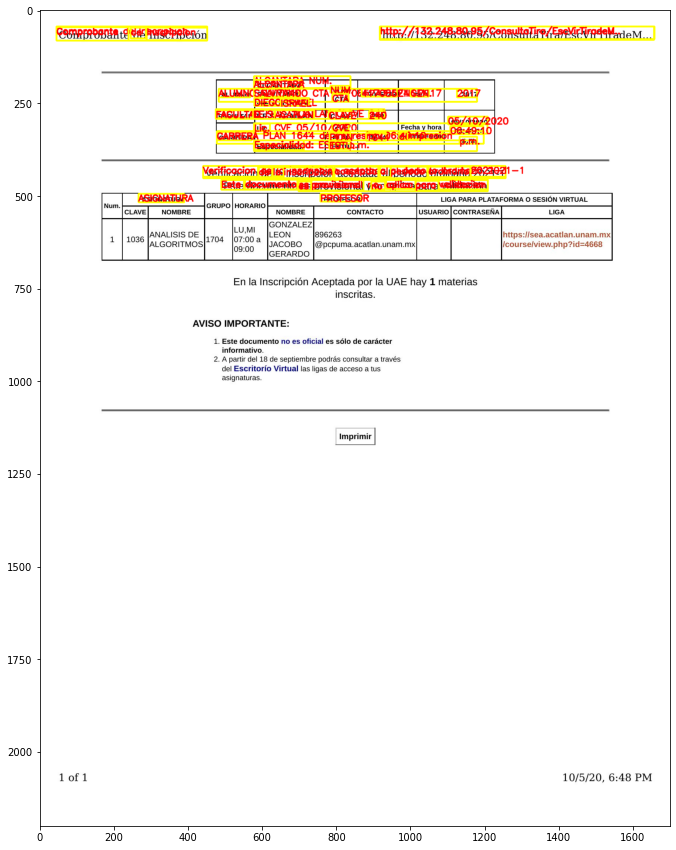

,DetectedText,Type,Confidence
0,Comprobante de Inscripcion,LINE,99.171051
1,http://132.248.80.95/ConsultaTira/EscVirTiradeM..,LINE,96.185562
2,ALCANTARA NUM.,LINE,96.703880
3,ALUMNO SALVITANO CTA 417085243 GEN. 2017,LINE,96.010963
4,DIEGO ISRAEL,LINE,96.164948
...,...,...,...
59,aplica,WORD,95.134026
60,para,WORD,95.942299
61,validacion,WORD,96.262665
62,ASIGNATURA,WORD,97.902473


In [8]:
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html#Rekognition.Client.detect_text

client_rekognition = boto3.client('rekognition', 'us-east-2')
detect_text = pd.DataFrame(
    client_rekognition.detect_text(
        Image={'Bytes': convert_img_to_bytes(file_path)}
    )['TextDetections']
)

img_bounding_boxes = cv2.imread(file_path)
for row in detect_text.itertuples():
    draw_bounding_box(
        img_bounding_boxes, 
        tuple(row.Geometry['BoundingBox'].values()), 
        row.DetectedText
    )
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_bounding_boxes)
plt.show()

detect_text[['DetectedText', 'Type', 'Confidence']]

### AWS Textract - Analyze document

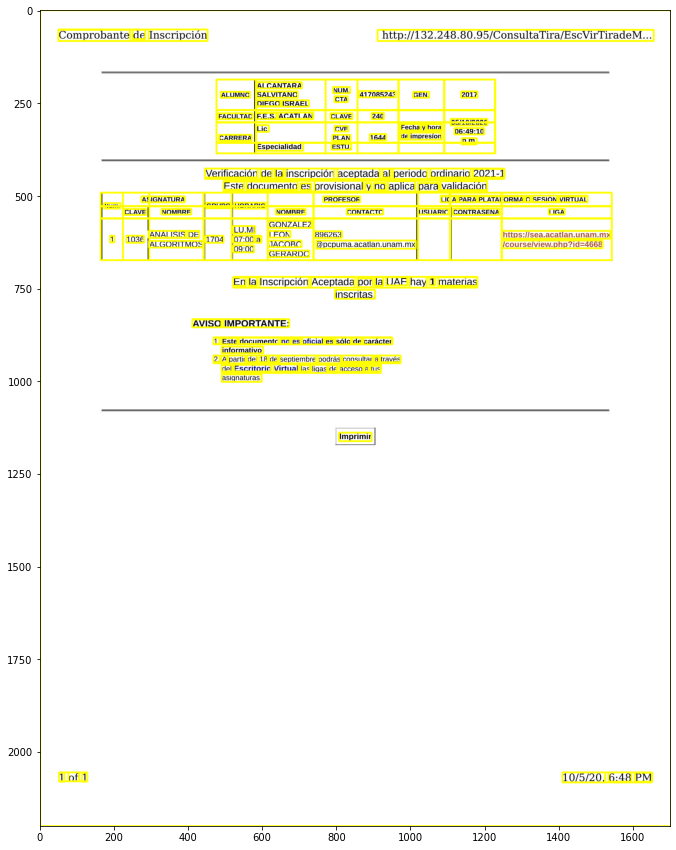

,Text,BlockType,Confidence,Relationships
0,NaN,PAGE,NaN,"[{'Type': 'CHILD', 'Ids': ['2a9900c6-8f4c-422e..."
1,Comprobante de Inscripcion,LINE,99.923866,"[{'Type': 'CHILD', 'Ids': ['611b04a2-495d-469d..."
2,http://132.248.80.95/ConsultaTira/EscVirTirade...,LINE,96.025681,"[{'Type': 'CHILD', 'Ids': ['d58de833-6a61-4089..."
3,ALCANTARA,LINE,99.861473,"[{'Type': 'CHILD', 'Ids': ['0bb1c3a1-89a1-4d31..."
4,NUM.,LINE,99.932884,"[{'Type': 'CHILD', 'Ids': ['664b0afb-266b-4e34..."
...,...,...,...,...
261,NaN,CELL,99.506630,"[{'Type': 'CHILD', 'Ids': ['7185ea7d-05f5-4188..."
262,NaN,CELL,99.506630,"[{'Type': 'CHILD', 'Ids': ['3886f22a-3be3-4981..."
263,NaN,CELL,99.506630,NaN
264,NaN,CELL,99.506630,NaN


In [9]:
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html#Textract.Client.analyze_document

client_textract = boto3.client('textract')
analyze_document = pd.DataFrame(
    client_textract.analyze_document(
        Document={'Bytes': convert_img_to_bytes(file_path)},
        FeatureTypes=['TABLES'],
    )['Blocks']
)

img_bounding_boxes = cv2.imread(file_path)
for row in analyze_document.itertuples():
    draw_bounding_box(
        img_bounding_boxes, 
        tuple(row.Geometry['BoundingBox'].values()), 
    )
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_bounding_boxes)
plt.show()

analyze_document[['Text', 'BlockType', 'Confidence', 'Relationships']]

### AWS Textract - Detect document text

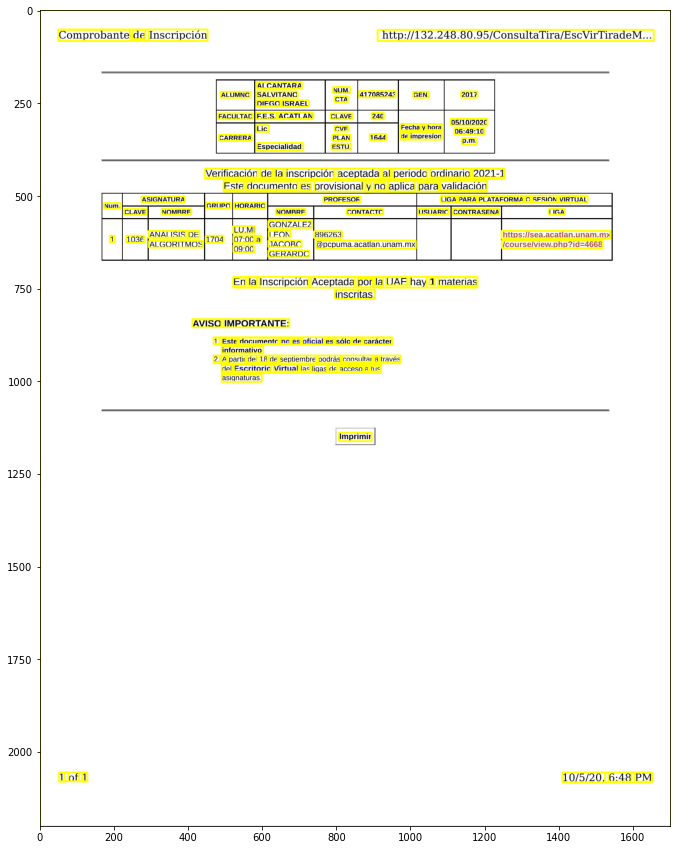

,BlockType,Geometry,Id,Relationships,Confidence,Text
0,PAGE,"{'BoundingBox': {'Width': 1.0, 'Height': 1.0, ...",da8d26e6-f59d-4ce2-aa6f-a3356e378765,"[{'Type': 'CHILD', 'Ids': ['1e7bc89d-de26-47de...",NaN,NaN
1,LINE,"{'BoundingBox': {'Width': 0.236614391207695, '...",1e7bc89d-de26-47de-9f3f-a6ae137c39af,"[{'Type': 'CHILD', 'Ids': ['ed96abba-eb90-43d4...",99.923866,Comprobante de Inscripcion
2,LINE,"{'BoundingBox': {'Width': 0.4379954934120178, ...",aaa29b04-bdc8-4c69-a97c-d29a4ed85e1c,"[{'Type': 'CHILD', 'Ids': ['d30894e5-b85a-4b44...",96.025681,http://132.248.80.95/ConsultaTira/EscVirTirade...
3,LINE,"{'BoundingBox': {'Width': 0.07149270176887512,...",1f7c77a9-b998-4fa9-890d-8252c2a96eb7,"[{'Type': 'CHILD', 'Ids': ['f5d39797-6c26-4421...",99.861473,ALCANTARA
4,LINE,{'BoundingBox': {'Width': 0.027193456888198853...,a0c08b55-b98b-46da-81e2-228d49b169ff,"[{'Type': 'CHILD', 'Ids': ['e0230458-00b4-45c5...",99.932884,NUM.
...,...,...,...,...,...,...
205,WORD,{'BoundingBox': {'Width': 0.017502829432487488...,a9744391-dc2a-4d31-8c26-6831d7111d9b,NaN,99.357147,of
206,WORD,{'BoundingBox': {'Width': 0.008518080227077007...,507cd5e6-5e1a-482e-affb-049ec3111420,NaN,98.551079,1
207,WORD,"{'BoundingBox': {'Width': 0.06808596104383469,...",ab112727-5f38-4137-860c-71b39632ff03,NaN,99.152184,"10/5/20,"
208,WORD,{'BoundingBox': {'Width': 0.036872539669275284...,57383a82-291c-4150-addc-fbc73d04c2ef,NaN,97.563492,6:48


In [10]:
# https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html#Textract.Client.detect_document_text

client_textract = boto3.client('textract')
detect_document_text = pd.DataFrame(
    client_textract.detect_document_text(
        Document={'Bytes': convert_img_to_bytes(file_path)},
    )['Blocks']
)

img_bounding_boxes = cv2.imread(file_path)
for row in detect_document_text.itertuples():
    draw_bounding_box(
        img_bounding_boxes, 
        tuple(row.Geometry['BoundingBox'].values()), 
    )
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_bounding_boxes)
plt.show()

detect_document_text